# Collating Results

<br><br>
___
### Cleaning Data

In [109]:
# !git clone https://github.com/Sakib56/MInf-2.0-DeepFake-Detection.git
# %cd "/content/MInf-2.0-DeepFake-Detection"

In [110]:
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import pandas as pd
import numpy as np
import ast
import os

sns.set()
plt.rc("font", family="serif")

# os.listdir(".")

In [171]:
def get_metric_from_file(fpath, metric="auc"):
    with open(fpath, "r") as f:
        experiment_name, _, _, _ = ast.literal_eval(f.readline().strip())  # (experiment_name, model_name, test_dataset, fpath)
        auc = f.readline()
        f1 = f.readline()
        prec = f.readline()
        recall = f.readline()
        metrics = {
            "auc": auc,
            "f1": f1,
            "prec": prec,
            "recall": recall,
        }
        if "tfpr" == metric or "ftpr" == metric:
            f.readline()
            fpr = f.readline()
            f.readline()
            tpr = f.readline()
            tpr = ast.literal_eval(tpr.strip().split("=")[-1])
            fpr = ast.literal_eval(fpr.strip().split("=")[-1])
            return tpr, fpr, experiment_name
    chosen_metric = metrics[metric.lower()]
    return float(chosen_metric.strip().split("=")[-1])


get_all_metrics = lambda t: [
    get_metric_from_file(t, "auc"),
    get_metric_from_file(t, "f1"),
    get_metric_from_file(t, "prec"),
    get_metric_from_file(t, "recall"),
]

COL_HDRS = ["Model", "AUC", "F1", "Precision", "Recall"]


def create_pd(model_results_txts, model_results_dir):
    model_results_txts = [
        f"{model_results_dir}{f}" for f in os.listdir(model_results_dir) if ".txt" in f
    ]
    tuple_list = [
        tuple([v.split("/")[-1].replace(".txt", "")] + get_all_metrics(v))
        for v in model_results_txts
    ]
    return pd.DataFrame(tuple_list, columns=COL_HDRS)


def categorise_names(t):
    tstst = t[-1].lower()
    if "run" in tstst:
        # cdfv2runningavg -> raeonCDFv2avg
        t[-1] = "rae" + t[-1].replace("running", "")
    if "on" in tstst:
        # raeondfavg -> raeDFavg
        t[-1] = t[-1].replace("on", "")
    if "cdfv2" in tstst:
        # cdfv2avg -> AVG
        t[-1] = t[-1].lower().replace("cdfv2", "").upper()
        # cdfv2runningavg -> raeAVG
        t[-1] = t[-1].replace("RAE", "rae")
    if t[-1] == "AVG" or t[-1] == "RND":
        # AVG -> CDFv2avg
        t[-1] = "CDFv2" + t[-1].lower()
        # print(tstst, t[-1])
    if t[-2] == "AVG" or t[-2] == "RND":
        t[-2] = "CDFv2" + t[-2].lower()

    return t


def welch_ttest(x1, x2, alternative):
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    tstat = (m1 - m2) / np.sqrt(v1 / n1 + v2 / n2)
    df = (v1 / n1 + v2 / n2) ** 2 / (
        v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1))
    )
    if alternative == "equal":
        p = 2 * t.cdf(-abs(tstat), df)
    if alternative == "lesser":
        p = t.cdf(tstat, df)
    if alternative == "greater":
        p = 1 - t.cdf(tstat, df)
    return tstat, df, p


def clean_latex(df):
    _df = df.copy()
    _df.loc[_df["Testset"] == "DFDB", "is_RAE"] = "-"
    _df.loc[_df["Testset"] == "DFDB", "is_AVG_Testset"] = "-"

    _df.loc[
        (_df["Trainset"] == "F2F") & (_df["Model_Name"] == "Meso4"), 
        "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "F2F") & (_df["Model_Name"] == "MesoInception"),
        "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "DF") & (_df["Model_Name"] == "Meso4"),
        "is_AVG_Trainset"] = "-"

    _df.loc[
        (_df["Trainset"] == "DF") & (_df["Model_Name"] == "MesoInception"),
        "is_AVG_Trainset"] = "-"

    latex_str = _df.to_latex(
        label="tab:best_models",
        column_format="c" * 10,
        index=True,
    )

    latex_str = latex_str.replace("Model\\_Name", "Model")
    latex_str = latex_str.replace("is\\_RAE", "Evaluation Method ( 0=SE, 1=RAE )")
    latex_str = latex_str.replace("is\\_AVG\\_Trainset", "Trainset Pre-Processing ( 0=RF, 1=AF )")
    latex_str = latex_str.replace("is\\_AVG\\_Testset", "Testset Pre-Processing ( 0=RF, 1=AF )")

    latex_str = latex_str.replace("Model_Name", "Model")
    latex_str = latex_str.replace("is_RAE", "Evaluation Method ( 0=SE, 1=RAE )")
    latex_str = latex_str.replace("is_AVG_Trainset", "Trainset Pre-Processing ( 0=RF, 1=AF )")
    latex_str = latex_str.replace("is_AVG_Testset", "Testset Pre-Processing ( 0=RF, 1=AF )")
    return latex_str


In [112]:
baseline_results_dir = "./_BASELINE_TESTS/Results/"
oc_fakedect1_results_dir = "./_TRAINING/OC-FakeDect-Implementation/Results/"
vit_results_dir = "./_TRAINING/ViT/Results/"


In [113]:
baseline_results_txts = [
    f"{baseline_results_dir}{f}"
    for f in os.listdir(baseline_results_dir)
    if ".txt" in f
]
oc_fakedect1_results_txts = [
    f"{oc_fakedect1_results_dir}{f}"
    for f in os.listdir(oc_fakedect1_results_dir)
    if ".txt" in f
]
vit_results_txts = [
    f"{oc_fakedect1_results_dir}{f}" 
    for f in os.listdir(vit_results_dir) 
    if ".txt" in f
]


In [114]:
vit_df = create_pd(vit_results_txts, vit_results_dir)
baseline_df = create_pd(baseline_results_txts, baseline_results_dir)
oc_fakedect1_df = create_pd(oc_fakedect1_results_txts, oc_fakedect1_results_dir)
df = pd.concat([vit_df, baseline_df, oc_fakedect1_df])
df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False] * 4)


In [115]:
# Find best
model_names_split = [(m, m.split("_")) for m in df["Model"]]
remove_list = [m for m, ms in model_names_split if len(ms) > 3]
print("Remove Rows", str(remove_list).replace(",", ",\n"), sep="\n")
df = df[~df["Model"].isin(remove_list)]
df["fname"] = df["Model"]

Remove Rows
['ViT_Celeb_rnd_30_0224_2353',
 'ViT_Celeb_rnd_30_0223_1926',
 'ViT_Celeb_rnd_30_train_0223_1755',
 'ViT_DariusAf_Deepfake_Database_0223_1831']


In [116]:
set([m.split("_")[0] for m in df["Model"]])  # Models look good

{'Meso4', 'MesoInception', 'OC-FakeDect1', 'ViT'}

In [117]:
set(
    [m.split("_")[1] for m in df["Model"]]
)  # Trainsets look good, NOTE: DF & F2F are only for Mesos

{'AVG', 'DF', 'DFDB', 'F2F', 'RND'}

In [118]:
set([m.split("_")[2] for m in df["Model"]])

{'CDFv2avg',
 'CDFv2rnd',
 'CDFv2runningavg',
 'CDFv2runningrnd',
 'DFDB',
 'DFavg',
 'DFrnd',
 'F2Favg',
 'F2Frnd',
 'FSHFTavg',
 'FSHFTrnd',
 'FSavg',
 'FSrnd',
 'NTavg',
 'NTrnd',
 'onAVG',
 'onDFDB',
 'onRND',
 'raeonAVG',
 'raeonDFavg',
 'raeonDFrnd',
 'raeonF2Favg',
 'raeonF2Frnd',
 'raeonFSHFTavg',
 'raeonFSHFTrnd',
 'raeonFSavg',
 'raeonFSrnd',
 'raeonNTavg',
 'raeonNTrnd',
 'raeonRND'}

In [119]:
model_names_split = [[m.split("_"), m] for m in df["Model"]]  # re-do bc df changed
cat_names_list = [
    categorise_names(ms) + [m] for ms, m in model_names_split
]  # for inner join on the df

# cat_names_list


In [120]:
df2 = pd.DataFrame(
    cat_names_list, columns=["Model_Name", "Trainset", "Testset", "Model"]
)
df = df2.merge(df, left_on="Model", right_on="Model")
df = df[[c for c in df.columns if c != "Model"]].sort_values(
    by=["AUC", "F1", "Precision", "Recall"], ascending=[False] * 4
)
df["Testset"] = df["Testset"].map(lambda x: x.replace("AVG", "CDFv2avg"))
df["Testset"] = df["Testset"].map(lambda x: x.replace("RND", "CDFv2rnd"))

pd.set_option("display.max_rows", df.shape[0] + 1)
df = df.round(3)
df = df.sort_values(by=["AUC", "F1", "Precision", "Recall"], ascending=[False] * 4)


In [121]:
df["is_RAE"] = 0
df.loc[df["Testset"].str.contains("rae"), "is_RAE"] = 1
df["is_AVG_Trainset"] = 0
df.loc[df["Trainset"].str.contains("avg"), "is_AVG_Trainset"] = 1
df["is_AVG_Testset"] = 0
df.loc[df["Testset"].str.contains("avg"), "is_AVG_Testset"] = 1
df["Testset"] = df["Testset"].replace(["CDFv2avg", "CDFv2rnd"], "CDFv2")
df["Testset"] = df["Testset"].map(lambda x: x.replace("rae", ""))
df["Testset"] = df["Testset"].map(lambda x: x.replace("avg", ""))
df["Testset"] = df["Testset"].map(lambda x: x.replace("rnd", ""))
df["Testset"] = df["Testset"].replace(["AVG"], "CDFv2")
df["Testset"] = df["Testset"].replace(["RND"], "CDFv2")
df["Trainset"] = df["Trainset"].map(lambda x: x.replace("avg", ""))
df["Trainset"] = df["Trainset"].map(lambda x: x.replace("rnd", ""))

df = df.drop_duplicates(
    subset=[
        "Model_Name",
        "Trainset",
        "Testset",
        "is_RAE",
        "is_AVG_Trainset",
        "is_AVG_Testset",
    ]
)
df.index = range(1, len(df) + 1)  # index from 1 for latex
dfid = df
df = df.drop(columns=["fname"])

<br><br>
___
### Data Showcase

#### Top AUC 20 Models

In [122]:
# DONT USE THIS IN PAPER (IT'S NOT USEFUL)
df[:20]  # all models sorted by AUC (top 20)

# print(clean_latex(df))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
2,Meso4,DF,DFDB,0.962,0.904,0.930,0.880,0,0,0
3,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
4,Meso4,F2F,F2F,0.905,0.128,0.118,0.139,1,0,0
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
6,ViT,CDFv2,CDFv2,0.860,0.953,0.944,0.964,1,1,0
7,ViT,CDFv2,CDFv2,0.857,0.963,0.932,0.996,1,1,1
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
9,MesoInception,DF,DF,0.844,0.174,0.159,0.190,1,0,0
10,ViT,CDFv2,CDFv2,0.831,0.960,0.930,0.993,0,0,0


#### Top AUC Models For Each Test Set

In [123]:
best_models = df.drop_duplicates(subset=["Testset"])
best_models

# print(clean_latex(best_models))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
3,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
28,Meso4,DF,FSHFT,0.704,0.380,0.316,0.476,1,0,0
50,ViT,CDFv2,NT,0.650,0.594,0.597,0.592,0,1,0
51,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,0,0,1


#### Top AUC Baselines Models For Each Test Set

In [124]:
best_baselines = df[df["Model_Name"].isin(["Meso4", "MesoInception"])]
best_baselines = best_baselines.drop_duplicates(subset=["Testset"])
best_baselines

# print(clean_latex(best_baselines))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,0,0,0
3,MesoInception,F2F,F2F,0.905,0.318,0.252,0.430,1,0,0
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,1,0,0
28,Meso4,DF,FSHFT,0.704,0.380,0.316,0.476,1,0,0
38,MesoInception,F2F,CDFv2,0.673,0.908,0.915,0.902,1,0,1
81,MesoInception,DF,NT,0.628,0.445,0.363,0.573,1,0,0
104,MesoInception,DF,FS,0.602,0.211,0.287,0.166,1,0,1


#### Top AUC ViT Models For Each Test Set

In [125]:
best_vits = df[df["Model_Name"].isin(["ViT"])]
best_vits = best_vits.drop_duplicates(subset=["Testset"])
best_vits

# print(clean_latex(best_vits))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,1,0,0
18,ViT,CDFv2,DF,0.770,0.661,0.511,0.933,1,1,0
21,ViT,CDFv2,DFDB,0.757,0.958,0.922,0.997,0,0,0
35,ViT,CDFv2,FSHFT,0.675,0.621,0.463,0.940,1,1,1
50,ViT,CDFv2,NT,0.650,0.594,0.597,0.592,0,1,0
61,ViT,CDFv2,F2F,0.646,0.601,0.440,0.946,1,0,0
74,ViT,CDFv2,FS,0.633,0.597,0.603,0.592,0,1,0


#### Top AUC OC-FakeDect1 Models For Each Test Set

In [126]:
best_ocfds = df[df["Model_Name"].isin(["OC-FakeDect1"])]
best_ocfds = best_ocfds.drop_duplicates(subset=["Testset"])
best_ocfds

# print(clean_latex(best_ocfds))


,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
48,OC-FakeDect1,DFDB,DF,0.651,0.380,0.298,0.525,0,0,0
51,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,0,0,1
52,OC-FakeDect1,DFDB,FSHFT,0.650,0.381,0.299,0.527,0,0,0
55,OC-FakeDect1,DFDB,NT,0.649,0.381,0.299,0.525,0,0,0
58,OC-FakeDect1,DFDB,F2F,0.648,0.382,0.300,0.528,0,0,1
66,OC-FakeDect1,DFDB,CDFv2,0.645,0.388,0.303,0.541,0,0,1
71,OC-FakeDect1,DFDB,DFDB,0.638,0.403,0.311,0.572,0,0,0


#### Top Generalisable AUC Models For Each Test Set _(Generalisable:= Trainset != Testset, i.e. Out of Trianing Dist.)_

In [127]:
dfx = df.loc[(df["Trainset"] != df["Testset"])].copy()
dfx["Trainset + Testset"] = df["Trainset"].astype(str) + df["Testset"].astype(str)
dfx = dfx.loc[(dfx["Trainset"] != dfx["Testset"])]
dfx = dfx.loc[dfx["Trainset + Testset"] != "DFDFDB"] # Only Meso4 & MesoInception have trian-test as DFDFDB
dfx = dfx.loc[dfx["Trainset + Testset"] != "F2FDFDB"] # Only Meso4 & MesoInception have trian-test as F2FDFDB
dfx = dfx.drop(columns=["Trainset + Testset"])
best_gen_models = dfx

best_gen_models.drop_duplicates(subset=["Testset"])

# print(clean_latex(
#     best_gen_models.drop_duplicates(subset=["Testset"])
#     ))

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,is_RAE,is_AVG_Trainset,is_AVG_Testset
18,ViT,CDFv2,DF,0.770,0.661,0.511,0.933,1,1,0
21,ViT,CDFv2,DFDB,0.757,0.958,0.922,0.997,0,0,0
28,Meso4,DF,FSHFT,0.704,0.380,0.316,0.476,1,0,0
38,MesoInception,F2F,CDFv2,0.673,0.908,0.915,0.902,1,0,1
50,ViT,CDFv2,NT,0.650,0.594,0.597,0.592,0,1,0
51,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,0,0,1
58,OC-FakeDect1,DFDB,F2F,0.648,0.382,0.300,0.528,0,0,1


<br><br>
___
## Analysis

### General

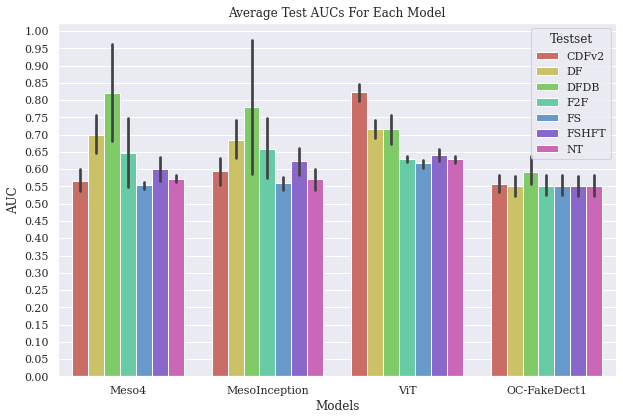

Bar_All


In [128]:
plt.figure(figsize=(10, 6.5))
# plot_order = df.groupby('Cause Name')['Deaths'].sum().sort_values(ascending=False).index.values
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="Testset",
    data=df,
    hue_order=['CDFv2', 'DF', 'DFDB', 'F2F', 'FS', 'FSHFT', 'NT'],
    order=['Meso4', 'MesoInception', 'ViT', 'OC-FakeDect1'],
    palette="hls",
)
title = f"Average Test AUCs For Each Model"
fname = "Bar_All"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


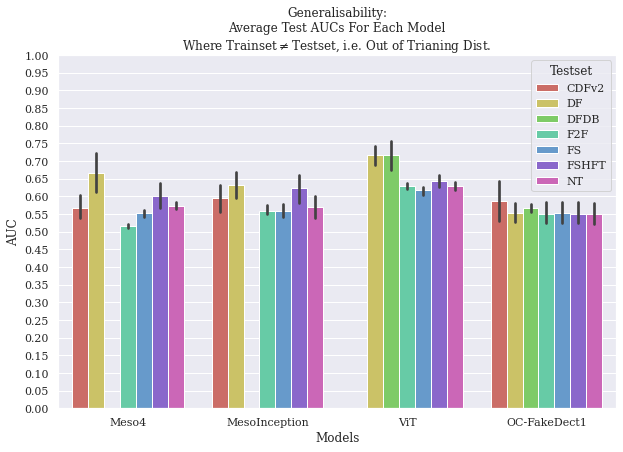

Bar_Generalisability


In [129]:
plt.figure(figsize=(10, 6.5))
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="Testset",
    data=best_gen_models,
    hue_order=['CDFv2', 'DF', 'DFDB', 'F2F', 'FS', 'FSHFT', 'NT'],
    order=['Meso4', 'MesoInception', 'ViT', 'OC-FakeDect1'],
    palette="hls",
)
title = f"Generalisability:\nAverage Test AUCs For Each Model\nWhere Trainset$\\neq$Testset, i.e. Out of Trianing Dist."
fname = "Bar_Generalisability"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


### Pre-Processing

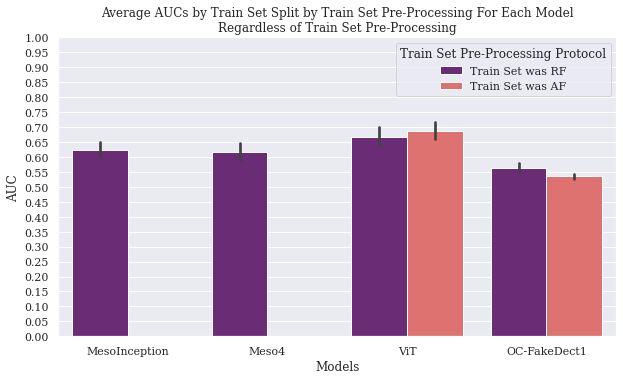

Model_AUCs_byTestPreProc


In [130]:
plt.figure(figsize=(10, 5.5))
ax = sns.barplot(
    x="Model_Name", 
    y="AUC", 
    hue="is_AVG_Trainset", 
    data=df, 
    palette="magma")
title = f"Average AUCs by Train Set Split by Train Set Pre-Processing For Each Model\nRegardless of Train Set Pre-Processing"
fname = "Model_AUCs_byTestPreProc"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Train Set was RF", "Train Set was AF"],
    loc="upper right",
    title=f"Train Set Pre-Processing Protocol",
)
# plt.savefig(
#     f"./_PLOTS/{fname}.pdf", 
#     bbox_inches="tight",
#     )
plt.show()
print(fname)


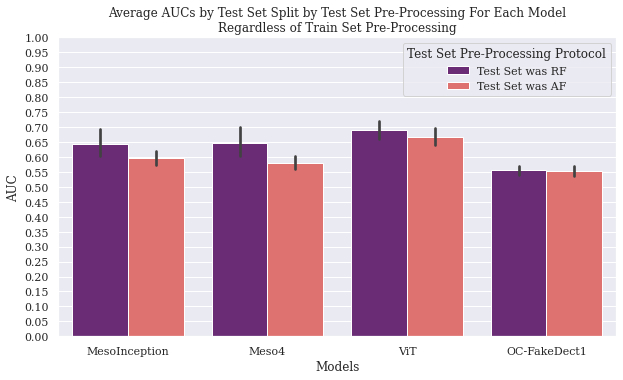

Model_AUCs_byTestPreProc


In [131]:
plt.figure(figsize=(10, 5.5))
ax = sns.barplot(
    x="Model_Name", 
    y="AUC", 
    hue="is_AVG_Testset", 
    data=df, 
    palette="magma")
title = f"Average AUCs by Test Set Split by Test Set Pre-Processing For Each Model\nRegardless of Train Set Pre-Processing"
fname = "Model_AUCs_byTestPreProc"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Test Set was RF", "Test Set was AF"],
    loc="upper right",
    title=f"Test Set Pre-Processing Protocol",
)
# plt.savefig(
#     f"./_PLOTS/{fname}.pdf", 
#     bbox_inches="tight",
#     )
plt.show()
print(fname)


In [132]:
# s1 = df.loc[(df["is_AVG_Testset"] == 1) & (df["is_AVG_Trainset"] == 1)].copy()
# s2 = df.loc[
#     (df["is_AVG_Testset"] == 0)
#     & (df["is_AVG_Trainset"] == 0)
#     & (df["Model_Name"] != "Meso4")
#     & (df["Model_Name"] != "MesoInception")].copy()

# s3 = df.loc[
#     (df["is_AVG_Testset"] == 1) 
#     & (df["is_AVG_Trainset"] == 0)
#     & (df["Model_Name"] != "Meso4")
#     & (df["Model_Name"] != "MesoInception")].copy()
# s4 = df.loc[
#     (df["is_AVG_Testset"] == 0)
#     & (df["is_AVG_Trainset"] == 1)
#     & (df["Model_Name"] != "Meso4")
#     & (df["Model_Name"] != "MesoInception")].copy()

# s1["is_TrainTest_PreProc_Alligned"] = 1
# s2["is_TrainTest_PreProc_Alligned"] = 1
# s3["is_TrainTest_PreProc_Alligned"] = 0
# s4["is_TrainTest_PreProc_Alligned"] = 0
# plt.figure(figsize=(10, 5.5))
# ax = sns.barplot(
#     x="Model_Name",
#     y="AUC",
#     hue="is_TrainTest_PreProc_Alligned",
#     data=pd.concat([s1, s2, s3, s4]),
#     palette="magma",
# )
# # title = f"Average AUCs by Test Set Split by Test Set Pre-Processing\nFor Each [Pre-Processing Protocol NOT Alligned] Model\ni.e. Trainset Pre-Processing Protocol != Testset Pre-Processing Protocol"
# # fname = "Model_AUCs_byTestPreProc_PreProcNOTAllign"
# # ax.set_title(title)
# ax.set_yticks(np.arange(0, 0.75, 0.05))
# # ax.set_xlabel("Models")
# # ax.legend(
# #     handles=ax.legend_.legendHandles,
# #     labels=["Test Set was RF but Train Set was AF", "Test Set was AF but Train Set was RF"],
# #     loc="upper right",
# #     title=f"Pre-Processing Protocol",
# # )
# # plt.savefig(
# #     f"./_PLOTS/{fname}.pdf", 
# #     bbox_inches="tight",
# #     )
# plt.show()
# # print(fname)


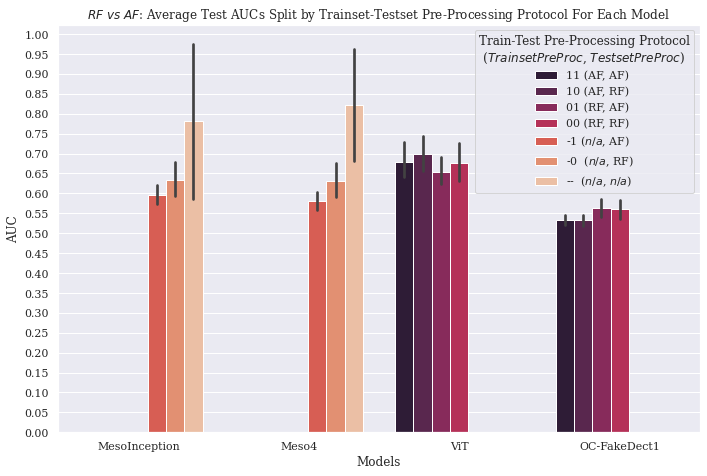

Bar_by_(TestTrain)PreProc


In [133]:
plt.figure(figsize=(11.5, 7.5))
dfx = df.copy()
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"

dfx["is_AVG_Trainset + is_AVG_Testset"] = dfx["is_AVG_Trainset"].astype(str) + dfx["is_AVG_Testset"].astype(str)
ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="is_AVG_Trainset + is_AVG_Testset",
    data=dfx,
    hue_order=["--", "-0", "-1", "00", "01", "10", "11"][::-1],
    palette="rocket"
)
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["--  ($n/a$, $n/a$)", "-0  ($n/a$, RF)", "-1 ($n/a$, AF)", "00 (RF, RF)", "01 (RF, AF)", "10 (AF, RF)", "11 (AF, AF)"][::-1],
    # loc="lower left",
    loc="best",
    title=f"Train-Test Pre-Processing Protocol\n{' '*1}($Trainset PreProc$, $Testset PreProc$)",
)
title = f"$RF$ $vs$ $AF$: Average Test AUCs Split by Trainset-Testset Pre-Processing Protocol For Each Model"
fname = "Bar_by_(TestTrain)PreProc"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


### Evaluation Method

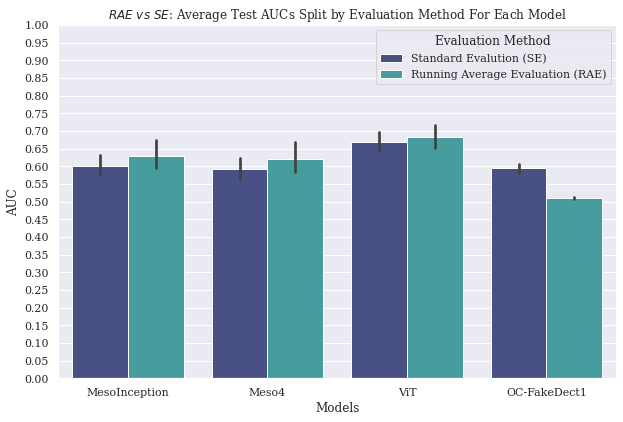

Bar_by_EvalMeth


In [134]:
plt.figure(figsize=(10, 6.5))
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx = dfx[~(dfx["is_RAE"] == "-")]

ax = sns.barplot(
    x="Model_Name",
    y="AUC",
    hue="is_RAE",
    data=dfx,
    palette="mako"
)
ax.legend(
    handles=ax.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 
            'Running Average Evaluation (RAE)'],
    title="Evaluation Method"
    )
title = f"$RAE$ $vs$ $SE$: Average Test AUCs Split by Evaluation Method For Each Model"
fname = "Bar_by_EvalMeth"
ax.set_title(title)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xlabel("Models")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


### Pre-Processing vs Evaluation Method

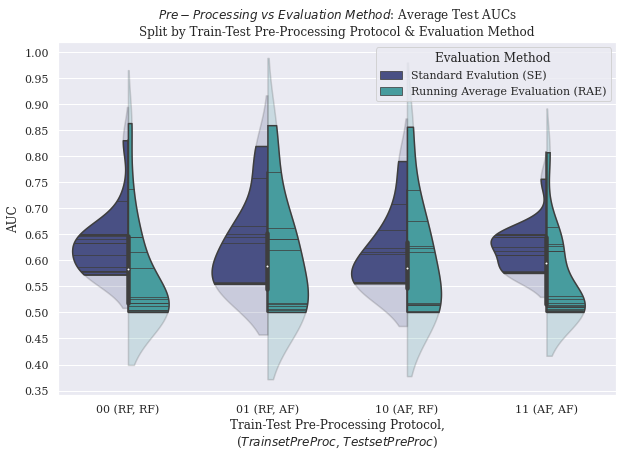

Violin_by_EvalMeth_N_(TrainTest)PreProc


In [135]:
plt.figure(figsize=(10, 6.5))
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: it's not actually RF and we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx = dfx[~(dfx["is_AVG_Trainset"] == "-")]
dfx = dfx[~(dfx["is_AVG_Testset"] == "-")]
dfx = dfx[~(dfx["is_RAE"] == "-")]
dfx["is_AVG_Trainset + is_AVG_Testset"] = dfx["is_AVG_Trainset"].astype(str) + dfx["is_AVG_Testset"].astype(str)


bx = sns.violinplot(
    x="is_AVG_Trainset + is_AVG_Testset",
    y="AUC",
    hue="is_RAE",
    data=dfx,
    inner="stick",
    split=True, 
    cut=2-.2,  
    palette="mako",
    aspect=1,
    height=100,
    alpha=[0.2, 0.2],
)
plt.setp(bx.collections, alpha=.2)
ax = sns.violinplot(
    x="is_AVG_Trainset + is_AVG_Testset",
    y="AUC",
    hue="is_RAE",
    data=dfx,
    split=True, 
    cut=0,  
    palette="mako",
    aspect=1,
    height=100,
    dodge=True,
)
ax.legend(
    handles=ax.legend_.legendHandles, 
    labels=['Standard Evalution (SE)', 
    'Running Average Evaluation (RAE)'],
    title="Evaluation Method"
    )
    
title = f"$Pre-Processing$ $vs$ $Evaluation$ $Method$: Average Test AUCs\nSplit by Train-Test Pre-Processing Protocol & Evaluation Method"
fname = "Violin_by_EvalMeth_N_(TrainTest)PreProc"
ax.set_title(title)
ax.set_xticklabels(["00 (RF, RF)", "01 (RF, AF)", "10 (AF, RF)", "11 (AF, AF)"],)
ax.set_yticks(np.arange(0.35, 1.025, 0.05))
ax.set_xlabel(f"Train-Test Pre-Processing Protocol,\n($Trainset PreProc$, $Testset PreProc$)")
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()
print(fname)


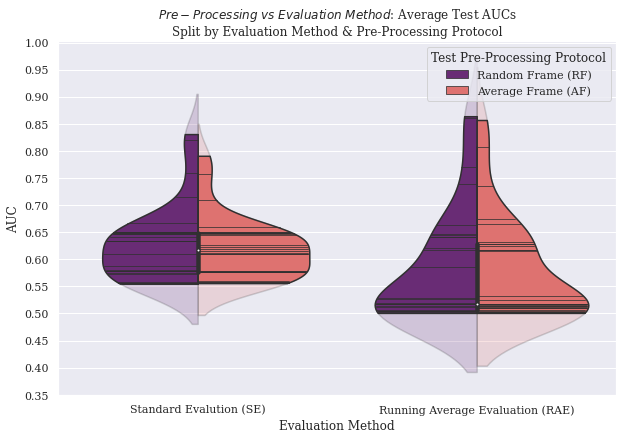

Violin_by_EvalMeth_N_PreProc


In [136]:
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: it's not actually RF and we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx = dfx[~(dfx["is_AVG_Trainset"] == "-")]
dfx = dfx[~(dfx["is_AVG_Testset"] == "-")]
dfx = dfx[~(dfx["is_RAE"] == "-")]

plt.figure(figsize=(10,6.5))

bx = sns.violinplot(
    x="is_RAE",
    y="AUC",
    hue="is_AVG_Testset",
    data=dfx,
    inner="stick",
    split=True, 
    # cut=2-.2,  
    palette="magma",
    aspect=1,
    height=100,
    alpha=[0.2, 0.2],
)
plt.setp(bx.collections, alpha=.2)
ax = sns.violinplot(
    x="is_RAE", 
    y='AUC', 
    hue="is_AVG_Testset", 
    data=dfx, 
    split=True, 
    cut=0,  
    palette="magma",
    aspect=1,
    height=100,
    )
ax.legend(
    handles=ax.legend_.legendHandles,
    labels=["Random Frame (RF)", "Average Frame (AF)"],
    loc="best",
    title="Test Pre-Processing Protocol",
)
title = f"$Pre-Processing$ $vs$ $Evaluation$ $Method$: Average Test AUCs\nSplit by Evaluation Method & Pre-Processing Protocol"
fname = "Violin_by_EvalMeth_N_PreProc"
ax.set_title(title);
ax.set_xticklabels(['Standard Evalution (SE)', 
                    'Running Average Evaluation (RAE)'])
ax.set_xlabel("Evaluation Method")
ax.set_ylabel("AUC")
ax.set_yticks(np.arange(0.35, 1.025, 0.05))
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight"
    )
plt.show()
print(fname)

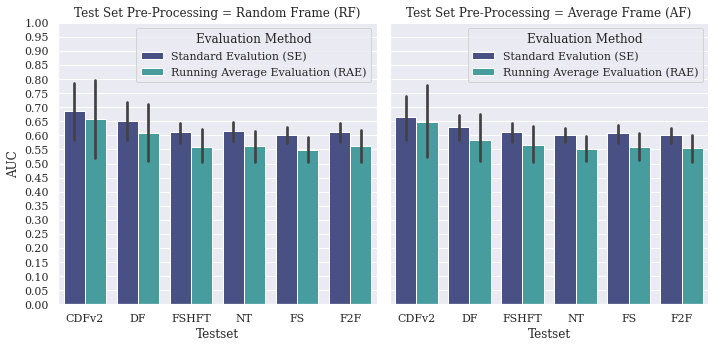

LBar_by_EvalMeth_N_TestPreProc


In [137]:
dfx = df.copy()
# IGNORE DFDB 
# Since it skews: it's not actually RF and we can't do RAE on it
# (but we can do SE, so it's not fair?) 
# So remove rows w/ "DFDB" (i.e. this graph only considers the datapoints which are applicable)
dfx.loc[dfx["Testset"] == "DFDB", "is_RAE"] = "-"
dfx.loc[dfx["Testset"] == "DFDB", "is_AVG_Testset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "F2F") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "Meso4"), "is_AVG_Trainset"] = "-"
dfx.loc[(dfx["Trainset"] == "DF") & (dfx["Model_Name"] == "MesoInception"), "is_AVG_Trainset"] = "-"
dfx = dfx[~(dfx["is_AVG_Trainset"] == "-")]
dfx = dfx[~(dfx["is_AVG_Testset"] == "-")]
dfx = dfx[~(dfx["is_RAE"] == "-")]

ax = sns.catplot(
    x="Testset",
    y="AUC",
    hue="is_RAE",
    hue_order=[0, 1],
    col="is_AVG_Testset",
    data=dfx,
    kind="bar",
    height=5,
    aspect=1,
    palette="mako",
    legend_out=False,
)
# ax.fig.suptitle(
#     f"Pre-Processing vs Evaluation Method:\nFurther In-Depth (Split by Test Set) AUC of All Models by Test Set Pre-Processing Protocall & Evaluation Method",
#     y=1.1,
#     fontdict={"weight": "bold"},
# )
ax.axes[0][0].set_title(f"Test Set Pre-Processing = Random Frame (RF)")
ax.axes[0][1].set_title(f"Test Set Pre-Processing = Average Frame (AF)")
ax, bx = ax.axes[0][0], ax.axes[0][1]
bx.legend()
bx.legend(
    handles=bx.legend_.legendHandles,
    labels=["Standard Evalution (SE)", "Running Average Evaluation (RAE)"],
    loc="best",
    title="Evaluation Method",
)
ax.legend(
    handles=bx.legend_.legendHandles,
    labels=["Standard Evalution (SE)", "Running Average Evaluation (RAE)"],
    loc="best",
    title="Evaluation Method",
)
ax.set_yticks(np.arange(0, 1.05, 0.05))
fname = "LBar_by_EvalMeth_N_TestPreProc"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight"
)
plt.show()
print(fname)


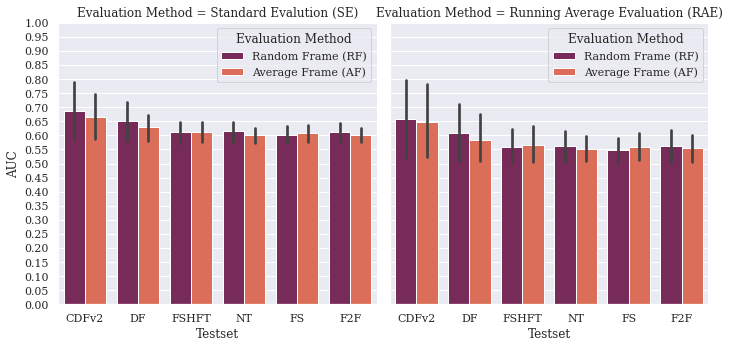

RBar_by_EvalMeth_N_TestPreProc


In [138]:
ax = sns.catplot(
    x="Testset",
    y="AUC",
    col="is_RAE",
    hue="is_AVG_Testset",
    data=dfx,
    kind="bar",
    hue_order=[0, 1],
    height=5,
    aspect=1,
    palette="rocket",
    legend_out=False,
)
# ax.fig.suptitle(
#     f"Pre-Processing vs Evaluation Method:\nFurther In-Depth (Split by Test Set) AUC of All Models by Test Set Pre-Processing Protocall & Evaluation Method",
#     y=1.1,
#     fontdict={"weight": "bold"},
# )
ax.axes[0][0].set_title(f"Evaluation Method = Standard Evalution (SE)")
ax.axes[0][1].set_title(f"Evaluation Method = Running Average Evaluation (RAE)")
ax, bx = ax.axes[0][0], ax.axes[0][1]
bx.legend()
bx.legend(
    handles=bx.legend_.legendHandles,
    labels=["Random Frame (RF)", "Average Frame (AF)"],
    loc="best",
    title="Evaluation Method",
)
ax.legend(
    handles=bx.legend_.legendHandles,
    labels=["Random Frame (RF)", "Average Frame (AF)"],
    loc="best",
    title="Evaluation Method",
)
ax.set_yticks(np.arange(0.0, 1.05, 0.05))
fname = "RBar_by_EvalMeth_N_TestPreProc"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight"
)
plt.show()
print(fname)


<br><br>
___
## T-Tests

For all t-tests we use generalisable models (`best_gen_models`) we're only considering models where trainset $\neq$ testset. This we can eliminate the correlation of testing on the set you trained on, and thus we can use the t-test!

### Running Average Evalution (RAE) vs Standard Evalution (SE)

In [139]:
print("RAE VARIED")
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
# including an id so that we can only consider paired models
# e.g. (Meso4, etc1) is comapred to (Meso4, etc2)
# where etc1 == etc2
A = "(RAE)"
a = dfx.loc[(dfx["is_RAE"] == 1)]
a = a.sort_values(by="id")

B = "(SE)"
b = dfx.loc[(dfx["is_RAE"] == 0)]
b =  b.loc[dfx["id"].isin([_ for _ in a["id"]])]
b = b.sort_values(by="id")

# Tests if alternative is TRUE
# Testing if the mean of the distribution underlying the first sample is
# greater than the mean of the distribution underlying the second sample.
alternative="less" 
_, p_value = ttest_rel(
    a["AUC"], 
    b["AUC"], 
    alternative=alternative
    )
alternative = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")
print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): "+(f"\n{A} {alternative} {B}" if p_value < 0.05 else f"REJECT {alternative}; Strong Evidence That Dists Are Equal"))


RAE VARIED
p-value 0.0016 < 0.05 (True): 
(RAE) << (SE)


In [140]:
print("RAE VARIED")
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
dfx = dfx.loc[~(dfx["Model_Name"]=="OC-FakeDect1")]
# including an id so that we can only consider paired models
# e.g. (Meso4, etc1) is comapred to (Meso4, etc2)
# where etc1 == etc2
A = "(RAE)"
a = dfx.loc[(dfx["is_RAE"] == 1)]
a = a.sort_values(by="id")

B = "(SE)"
b = dfx.loc[(dfx["is_RAE"] == 0)]
b =  b.loc[dfx["id"].isin([_ for _ in a["id"]])]
b = b.sort_values(by="id")

# Tests if alternative is TRUE
# Testing if the mean of the distribution underlying the first sample is
# greater than the mean of the distribution underlying the second sample.
alternative="greater" 
_, p_value = ttest_rel(
    a["AUC"], 
    b["AUC"], 
    alternative=alternative
    )
alternative = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")
print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): "+(f"\n{A} {alternative} {B}" if p_value < 0.05 else f"REJECT {alternative}; Strong Evidence That Dists Are Equal"))


RAE VARIED
p-value 0.0004 < 0.05 (True): 
(RAE) >> (SE)


### Running Average Evalution (RAE) vs Standard Evalution (SE)
### When Test Pre-Processing is RF/AF


In [141]:
# WHEN RF
print("RAE VARIED WHEN RF")
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
# including an id so that we can only consider paired models
# e.g. (Meso4, etc1) is comapred to (Meso4, etc2)
# where etc1 == etc2
A = "(RAE and RF)"
a = dfx.loc[(dfx["is_RAE"] == 1) & (dfx["is_AVG_Testset"]==0)]
a = a.sort_values(by="id")

B = "(SE and RF)"
b = dfx.loc[(dfx["is_RAE"] == 0) & (dfx["is_AVG_Testset"]==0)]
b =  b.loc[dfx["id"].isin([_ for _ in a["id"]])]
b = b.sort_values(by="id")

# Tests if alternative is TRUE
# Testing if the mean of the distribution underlying the first sample is
# less than the mean of the distribution underlying the second sample.
alternative="less" 
_, p_value = ttest_rel(
    a["AUC"], 
    b["AUC"], 
    alternative=alternative
    )
alternative = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")
print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): "+(f"\n{A} {alternative} {B}" if p_value < 0.05 else f"REJECT {alternative}; Strong Evidence That Dists Are Equal"))


RAE VARIED WHEN RF
p-value 0.0174 < 0.05 (True): 
(RAE and RF) << (SE and RF)


In [142]:
# WHEN AF
print("RAE VARIED WHEN AF")
dfx = best_gen_models.copy()
dfx["id"] = df["Model_Name"].astype(str) + df["Trainset"].astype(str) + df["Testset"].astype(str)
# including an id so that we can only consider paired models
# e.g. (Meso4, etc1) is comapred to (Meso4, etc2)
# where etc1 == etc2

A = "(RAE and AF)"
a = dfx.loc[(dfx["is_RAE"] == 1) & (dfx["is_AVG_Testset"]==1)]
a = a.sort_values(by="id")

B = "(SE and AF)"
b = dfx.loc[(dfx["is_RAE"] == 0) & (dfx["is_AVG_Testset"]==1)]
b =  b.loc[dfx["id"].isin([_ for _ in a["id"]])]
b = b.sort_values(by="id")

# Tests if alternative is TRUE
# Testing if the mean of the distribution underlying the first sample is
# less than the mean of the distribution underlying the second sample.
alternative="less" 
_, p_value = ttest_rel(
    a["AUC"], 
    b["AUC"], 
    alternative=alternative
    )
alternative = alternative.replace("two-sided", "!=").replace("less", "<<").replace("greater", ">>")
print(f"p-value {p_value:.4f} < 0.05 ({p_value < 0.05}): "+(f"\n{A} {alternative} {B}" if p_value < 0.05 else f"REJECT {alternative}; Strong Evidence That Dists Are Equal"))

RAE VARIED WHEN AF
p-value 0.0104 < 0.05 (True): 
(RAE and AF) << (SE and AF)


<br><br>
___
## AUC Plots

In [228]:
dfx = dfid.loc[(dfid["Trainset"] != dfid["Testset"])].copy()
dfx["Trainset + Testset"] = dfid["Trainset"].astype(str) + dfid["Testset"].astype(str)
dfx = dfx.loc[(dfx["Trainset"] != dfx["Testset"])]
dfx = dfx.loc[dfx["Trainset + Testset"] != "DFDFDB"] # Only Meso4 & MesoInception have trian-test as DFDFDB
dfx = dfx.loc[dfx["Trainset + Testset"] != "F2FDFDB"] # Only Meso4 & MesoInception have trian-test as F2FDFDB
dfx = dfx.drop(columns=["Trainset + Testset"])
dfid_best_gen_models = dfx

dfid_best_gen_models = dfid_best_gen_models.drop_duplicates(subset=["Testset"]).drop_duplicates(subset=["Model_Name"])
# dfid_best_gen_models

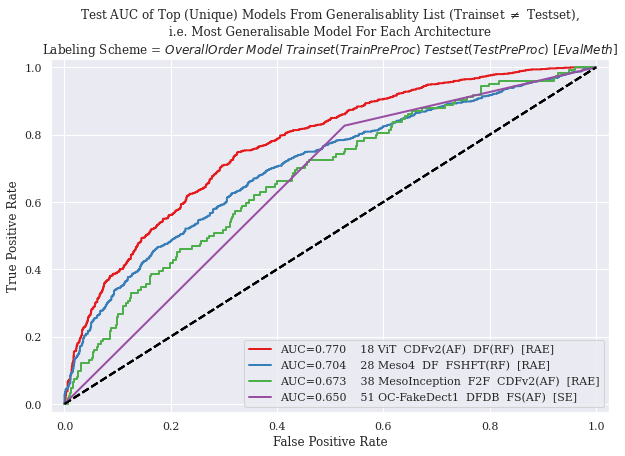

In [242]:
plt.figure(figsize=(10, 6.5))
sns.set_palette("Set1")
for model_fname in dfid_best_gen_models["fname"]:
    try:
        tpr, fpr, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "tfpr")
    except FileNotFoundError:
        try: 
            tpr, fpr, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "tfpr")
        except FileNotFoundError:
            try: 
                tpr, fpr, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "tfpr")
            except FileNotFoundError:
                print("Error?")
                break

    picked_model = dfid_best_gen_models.loc[dfid_best_gen_models["fname"] == model_fname]

    auroc = picked_model["AUC"]
    picked_model.index

    model_fname = model_fname.replace("AVG", "CDFv2(AF)").replace("RND", "CDFv2(RF)")
    model_fname = model_fname.replace("avg", "(AF)").replace("rnd", "(RF)")
    model_fname = model_fname.replace("_on", "")
    if "raeon" in model_fname or "running" in model_fname:
        model_fname = model_fname.replace("raeon", "")
        model_fname = model_fname.replace("running", "")
        model_fname = f"{model_fname}_[RAE]"
    else:
        model_fname = f"{model_fname}_[SE]"
    model_fname = model_fname.replace("_", "  ")
    model_fname = f"{picked_model.index[0]} {model_fname}"
    model_fname = f"AUC={float(auroc):.3f}    {model_fname}"
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label=model_fname)#f'{model_fname}     [Area = %0.3f]' % auroc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title(f"AUROC of {experiment_name}")
    plt.title(f"Test AUC of Top (Unique) Models From Generalisablity List (Trainset $\\neq$ Testset),\ni.e. Most Generalisable Model For Each Architecture\nLabeling Scheme = $OverallOrder$ $Model$ $Trainset(TrainPreProc)$ $Testset(TestPreProc)$ $[EvalMeth]$")
    plt.legend(loc="lower right")
fname = f"AUC_Most_Gen"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()

In [238]:
dfx = dfid.drop_duplicates(subset=["Testset"]).copy()
dfid_best_models = dfx

dfid_best_models = dfid_best_models.drop_duplicates(subset=["Testset"]).drop_duplicates(subset=["Model_Name"])
dfid_best_models

,Model_Name,Trainset,Testset,AUC,F1,Precision,Recall,fname,is_RAE,is_AVG_Trainset,is_AVG_Testset
1,MesoInception,DF,DFDB,0.975,0.925,0.953,0.900,MesoInception_DF_DFDB,0,0,0
5,ViT,CDFv2,CDFv2,0.864,0.963,0.930,0.999,ViT_RND_raeonRND,1,0,0
8,Meso4,DF,DF,0.856,0.175,0.159,0.194,Meso4_DF_raeonDFrnd,1,0,0
51,OC-FakeDect1,DFDB,FS,0.650,0.381,0.299,0.527,OC-FakeDect1_DFDB_FSavg,0,0,1


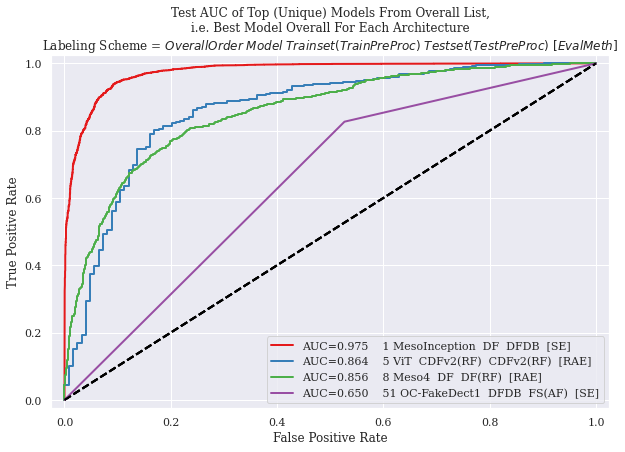

In [245]:
plt.figure(figsize=(10, 6.5))
sns.set_palette("Set1")
for model_fname in dfid_best_models["fname"]:
    try:
        tpr, fpr, experiment_name = get_metric_from_file(f"{vit_results_dir}{model_fname}.txt", "tfpr")
    except FileNotFoundError:
        try: 
            tpr, fpr, experiment_name = get_metric_from_file(f"{baseline_results_dir}{model_fname}.txt", "tfpr")
        except FileNotFoundError:
            try: 
                tpr, fpr, experiment_name = get_metric_from_file(f"{oc_fakedect1_results_dir}{model_fname}.txt", "tfpr")
            except FileNotFoundError:
                print("Error?")
                break

    picked_model = dfid_best_models.loc[dfid_best_models["fname"] == model_fname]

    auroc = picked_model["AUC"]
    picked_model.index

    model_fname = model_fname.replace("AVG", "CDFv2(AF)").replace("RND", "CDFv2(RF)")
    model_fname = model_fname.replace("avg", "(AF)").replace("rnd", "(RF)")
    model_fname = model_fname.replace("_on", "")
    if "raeon" in model_fname or "running" in model_fname:
        model_fname = model_fname.replace("raeon", "")
        model_fname = model_fname.replace("running", "")
        model_fname = f"{model_fname}_[RAE]"
    else:
        model_fname = f"{model_fname}_[SE]"
    model_fname = model_fname.replace("_", "  ")
    model_fname = f"{picked_model.index[0]} {model_fname}"
    model_fname = f"AUC={float(auroc):.3f}    {model_fname}"
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label=model_fname)#f'{model_fname}     [Area = %0.3f]' % auroc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title(f"AUROC of {experiment_name}")
    plt.title(f"Test AUC of Top (Unique) Models From Overall List,\ni.e. Best Model Overall For Each Architecture\nLabeling Scheme = $OverallOrder$ $Model$ $Trainset(TrainPreProc)$ $Testset(TestPreProc)$ $[EvalMeth]$")
    plt.legend(loc="lower right")
fname = f"AUC_Best_Overall"
plt.savefig(
    f"./_PLOTS/{fname}.pdf", 
    bbox_inches="tight",
    )
plt.show()